The aim of this notebook is to by optimising the position and dwell times of point sources along constrained lines produce a minimum exposure to one cube while producing a maximum exposure to a second cube.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

# from IPython.parallel import Client

from utilities import BasinhoppingWrapper

Load parrallel clients for multithreading

In [2]:
# client = Client()
# view = client[:]
# client.ids

Create the calculation grid

In [3]:
x_ = np.arange(-1, 1.1, 0.1)
y_ = np.arange(-1, 1.1, 0.1)
z_ = np.arange(-1, 1.1, 0.1)

x, y, z = np.meshgrid(x_, y_, z_)
x = np.ravel(x)
y = np.ravel(y)
z = np.ravel(z)

Define the target and avoid cubes

In [4]:
target_cube = (
    (x < 0.45) & (x > -0.45) & 
    (y < 0.45) & (y > -0.45) & 
    (z < 0.45) & (z > -0.45))

avoid_cube = (
    (x < 0.85) & (x > 0.55) & 
    (y < 0.15) & (y > -0.15) & 
    (z < 0.15) & (z > -0.15))

other = (~target_cube) & (~avoid_cube)

Define the immediate exterior to the surface

In [5]:
# target_distances = (
#     (np.reshape(x[~target_cube], (-1, 1)) - 
#      np.reshape(x[target_cube], (1, -1)))**2 +
#     (np.reshape(y[~target_cube], (-1, 1)) - 
#      np.reshape(y[target_cube], (1, -1)))**2 +
#     (np.reshape(z[~target_cube], (-1, 1)) - 
#      np.reshape(z[target_cube], (1, -1)))**2
# )

# shortest_dist_to_external = np.min(target_distances, axis=1)
# target_exterior = (
#     shortest_dist_to_external < np.min(shortest_dist_to_external) 
#     + 0.00001)

Display the target and avoid cubes

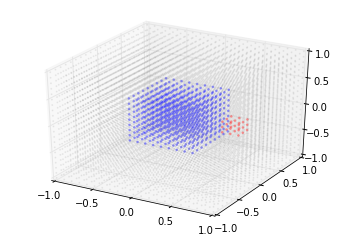

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
# ax.scatter(
#     x[~target_cube][target_exterior], 
#     y[~target_cube][target_exterior], 
#     z[~target_cube][target_exterior],
#     alpha=0.3, s=3, color='yellow')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

plt.show()

Create initial equidistant parrallel lines with a random skew

In [7]:
number_of_lines = 16

line_start = np.meshgrid(
    [-0.3, -0.1, 0.1, 0.3],
    [-0.3, -0.1, 0.1, 0.3],
    [1])

line_finish = np.array([
    line_start[0] + np.random.normal(scale=0.05, size=[4, 4, 1]),
    line_start[1] + np.random.normal(scale=0.05, size=[4, 4, 1]),
    -line_start[2]])

In [8]:
line_start = np.array([np.ravel(mesh) for mesh in line_start])
line_finish = np.array([np.ravel(mesh) for mesh in line_finish])

Display the lines overlayed

(-1, 1)

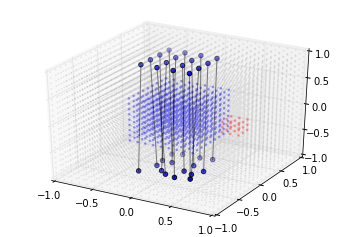

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
# ax.scatter(
#     x[~target_cube][target_exterior], 
#     y[~target_cube][target_exterior], 
#     z[~target_cube][target_exterior],
#     alpha=0.3, s=3, color='yellow')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')
ax.scatter(*line_start)
ax.scatter(*line_finish)

for i in range(len(line_start[0])):
    plt_coords = [
        [line_start[j][i], line_finish[j][i]]
        for j in range(len(line_start))]
    ax.plot(*plt_coords, color='black', alpha=0.5)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create a function to return x, y, z coords when a distance along a line is requested

In [10]:
diff = (line_finish - line_start)
line_length = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)

def find_distance_coords(line_num=None, distance=None):
    relative_dist = distance / line_length[line_num]
    
    if (relative_dist > 1) | (relative_dist < 0):
        return np.array([np.nan]*3)
    
    x = (
        line_start[0][line_num] * (1 - relative_dist) + 
        line_finish[0][line_num] * relative_dist)
    
    y = (
        line_start[1][line_num] * (1 - relative_dist) + 
        line_finish[1][line_num] * relative_dist)
        
    z = (
        line_start[2][line_num] * (1 - relative_dist) + 
        line_finish[2][line_num] * relative_dist)
    
    coords = np.array([x, y, z])
    
    return coords

Pick dwell positons 0.2 units apart starting at a random position along the line

In [11]:
dwell_spacing = 0.2
number_of_dwells = np.floor(2 / dwell_spacing).astype(int)

In [12]:
inital_dwell_position = np.random.uniform(
    low=0, high=dwell_spacing, size=number_of_lines)
inital_dwell_position

array([ 0.06466935,  0.13121627,  0.02928629,  0.06209673,  0.1833869 ,
        0.08956469,  0.10015114,  0.11273126,  0.12811097,  0.19623726,
        0.16549494,  0.14788131,  0.14939692,  0.13435826,  0.06382288,
        0.1371894 ])

In [13]:
def find_dwell_coords(line_num=None, dwell_num=None):
    distance = (inital_dwell_position[line_num] + 
                dwell_num * dwell_spacing)
    
    coords = find_distance_coords(
        line_num=line_num, distance=distance)
    
    return coords

In [14]:
dwell_positions = np.array([
    [
        find_dwell_coords(
            line_num=line_num, dwell_num=dwell_num)
        for dwell_num in range(number_of_dwells)]
 for line_num in range(number_of_lines)])

In [15]:
relevant_dwell_positions = np.reshape(dwell_positions, (-1, 3))
keep = ((relevant_dwell_positions[:,2] < 0.45) & 
        (relevant_dwell_positions[:,2] > -0.45))
relevant_dwell_positions = relevant_dwell_positions[keep]

Plot the dwell positions

(-1, 1)

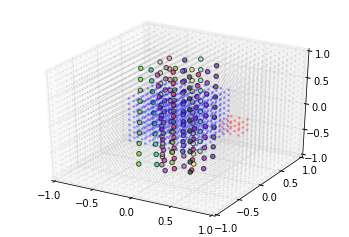

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
# ax.scatter(
#     x[~target_cube][target_exterior], 
#     y[~target_cube][target_exterior], 
#     z[~target_cube][target_exterior],
#     alpha=0.3, s=3, color='yellow')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')

for line_num in range(number_of_lines):
    colour = np.random.uniform(size=3)
    ax.scatter(*np.transpose(dwell_positions[line_num]), 
               c=colour, alpha=0.7)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create an array containing the distance to each dwell position for each voxel and translate this to exposure at that voxel per unit dwell time at each dwell position

In [17]:
distance_to_dwell_pos = np.array([
    np.sqrt(
        (x[i] - relevant_dwell_positions[:,0])**2 + 
        (y[i] - relevant_dwell_positions[:,1])**2 + 
        (z[i] - relevant_dwell_positions[:,2])**2
    )
    for i in range(len(x))
])

exposure_per_unit_time = 1 / distance_to_dwell_pos**2
# view.push({'exposure_per_unit_time': exposure_per_unit_time})

Create exposure calculation function

In [18]:
# @view.parallel(block=True)
# def dwell_multiply(dwell_times):
#     return dwell_times * exposure_per_unit_time

# def calculate_exposure(dwell_times):
#     dwell_multiply_result = dwell_multiply(dwell_times)
#     exposure = np.sum(dwell_multiply_result, axis=1)
    
#     view.results.clear()
#     client.results.clear()
#     client.metadata.clear()
    
#     return exposure

def calculate_exposure(dwell_times):
    exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
    
    return exposure

Run a test of arbitrary dwell times

In [19]:
num_relevant_dwells = len(relevant_dwell_positions)

random_pick = np.random.uniform(
    size=2, high=num_relevant_dwells, low=0).astype(int)

dwell_times = np.zeros([1, num_relevant_dwells])
dwell_times[0, random_pick] = 10

exposure = calculate_exposure(dwell_times)

(-1, 1)

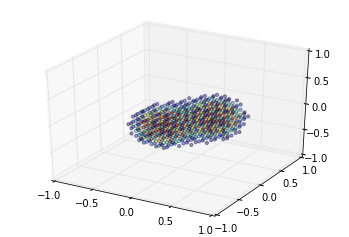

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

reference = exposure > 80
colour = exposure[reference]
colour[colour > 200] = 200

ax.scatter(
    x[reference], y[reference], z[reference], 
    alpha=0.4, s=10, c=colour, cmap=cm.jet)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

In [21]:
def display_results(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    reference = exposure > 25
    colour = exposure[reference]
    colour[colour > 100] = 100
    
    small = exposure[reference] < 50
    large = ~small

    ax.scatter(
        x[reference][small], y[reference][small], z[reference][small], 
        alpha=0.2, s=3, c=colour[small], cmap=cm.jet)
    
    ax.scatter(
        x[reference][large], y[reference][large], z[reference][large], 
        alpha=0.4, s=20, c=colour[large], cmap=cm.jet)


    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    cost_function(dwell_times, debug=True)
    
    plt.show()

Create cost function

(0, 20)

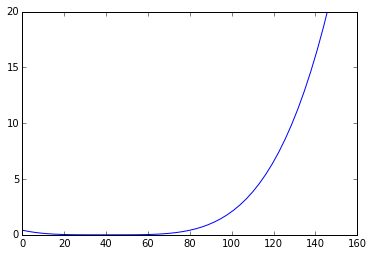

In [22]:
def hot_exterior_cost_function(max_target_exterior):
    return ((max_target_exterior-40)/50)**4

testx = np.linspace(0, 150)
testy = hot_exterior_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

(0, 20)

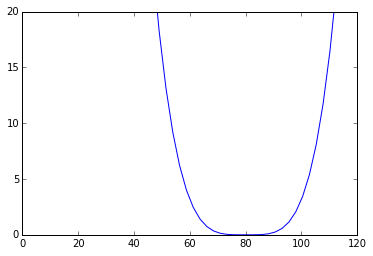

In [23]:
def cold_target_cost_function(min_target):
    return ((min_target-80)/15)**4

testx = np.linspace(0, 120)
testy = cold_target_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

(0, 20)

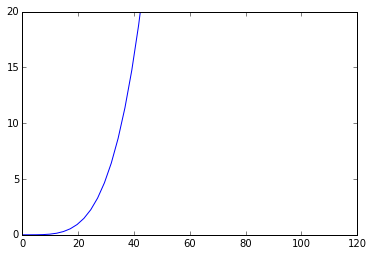

In [24]:
def hot_avoid_cost_function(max_avoid):
    return ((max_avoid)/20)**4

testx = np.linspace(0, 120)
testy = hot_avoid_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

In [25]:
def cost_function(dwell_times, debug=False):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    min_target = np.min(exposure[target_cube])
    max_avoid = np.max(exposure[avoid_cube])
    max_target_exterior = np.max(exposure[~target_cube])
    
    cold_target_cost = cold_target_cost_function(min_target)
    hot_exterior_cost = hot_exterior_cost_function(max_target_exterior)
    hot_avoid_cost = hot_avoid_cost_function(max_avoid)
    
    total_cost = hot_exterior_cost + cold_target_cost + hot_avoid_cost
    
    if debug:
        print("Minimum target = %0.4f, resulting cost = %0.4f" %
              (min_target, cold_target_cost))
        print("Maximum exterior = %0.4f, resulting cost = %0.4f" %
              (max_target_exterior, hot_exterior_cost))
        print("Maximum avoid = %0.4f, resulting cost = %0.4f" %
              (max_avoid, hot_avoid_cost))
        print("Total cost = %0.4f" % (total_cost))
        
    
    return total_cost

Create initial conditions

In [26]:
num_relevant_dwells

68

In [27]:
initial_conditions = np.ones(num_relevant_dwells)*0.1

Step noise

In [28]:
step_noise = np.ones(num_relevant_dwells) * 0.3

Bounds

In [29]:
bounds = ((0, None),)*num_relevant_dwells

Run the optimiser

Minimum target = 56.5188, resulting cost = 6.0051
Maximum exterior = 80.2183, resulting cost = 0.4186
Maximum avoid = 37.7043, resulting cost = 12.6312
Total cost = 19.0549


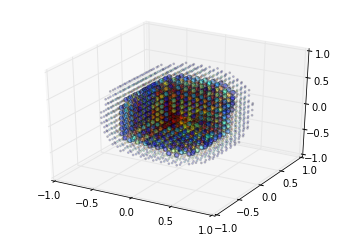

Minimum target = 57.2428, resulting cost = 5.2980
Maximum exterior = 79.5816, resulting cost = 0.3927
Maximum avoid = 38.0136, resulting cost = 13.0507
Total cost = 18.7414


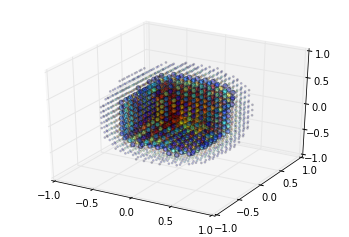

In [30]:
optimisation = BasinhoppingWrapper(
    to_minimise=cost_function,
    initial=initial_conditions,
    step_noise=step_noise,
    basinhopping_confidence=2,
    optimiser_confidence=0.0001,
    n=2,
    debug=display_results,
    bounds=bounds
)

Minimum target = 57.2428, resulting cost = 5.2980
Maximum exterior = 79.5816, resulting cost = 0.3927
Maximum avoid = 38.0136, resulting cost = 13.0507
Total cost = 18.7414


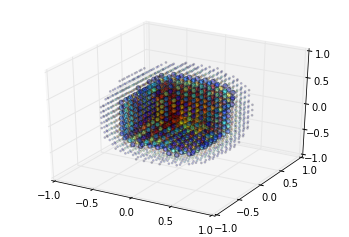

In [31]:
display_results(optimisation.result)

(array([ 41.,  11.,   8.,   0.,   2.,   2.,   2.,   1.,   0.,   1.]),
 array([ 0.        ,  0.1718749 ,  0.34374981,  0.51562471,  0.68749962,
         0.85937452,  1.03124942,  1.20312433,  1.37499923,  1.54687413,
         1.71874904]),
 <a list of 10 Patch objects>)

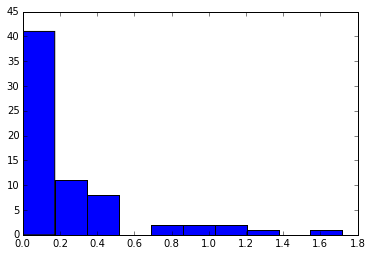

In [32]:
plt.hist(optimisation.result)

Convert result into column vector for post analysis

In [33]:
dwell_times = np.reshape(optimisation.result, (1, num_relevant_dwells))

Create a custom resolution exposure calculation function for post analysis

In [34]:
def custom_res_calculate_exposure(dwell_times, dx=0.1, dy=0.1, dz=0.1):
    x_ = np.arange(-1, 1 + dx, dx)
    y_ = np.arange(-1, 1 + dy, dy)
    z_ = np.arange(-1, 1 + dz, dz)

    x, y, z = np.meshgrid(
        x_, y_, z_)
    x = np.ravel(x)
    y = np.ravel(y)
    z = np.ravel(z)

    distance_to_dwell_pos = np.array([
        np.sqrt(
            (x[i] - relevant_dwell_positions[:,0])**2 + 
            (y[i] - relevant_dwell_positions[:,1])**2 + 
            (z[i] - relevant_dwell_positions[:,2])**2
        )
        for i in range(len(x))
    ])

    exposure_per_unit_time = 1 / distance_to_dwell_pos**2
    
    exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)    
    return exposure

In [42]:
contour_exposure = custom_res_calculate_exposure(dwell_times, dx=0.01, dy=0.01)

contour_exposure = np.reshape(exposure, (
    201, 201, 21))
contour_exposure[contour_exposure > 250] = 250

contour_x_ = np.arange(-1, 1 + 0.01, 0.01)
contout_y_ = np.arange(-1, 1 + 0.01, 0.01)

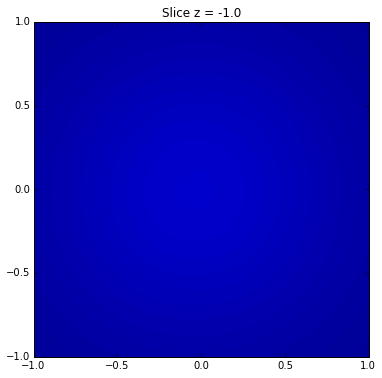

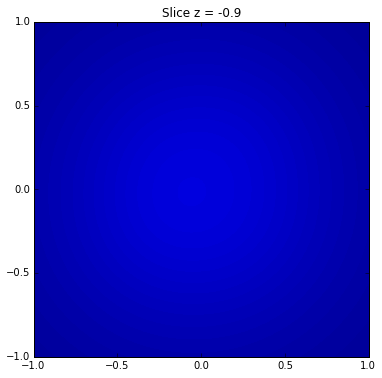

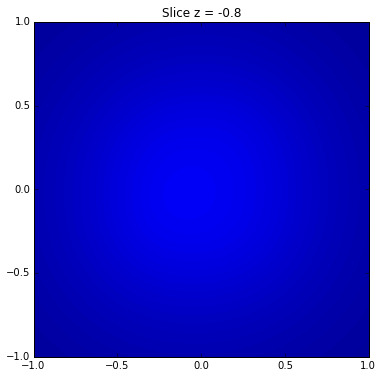

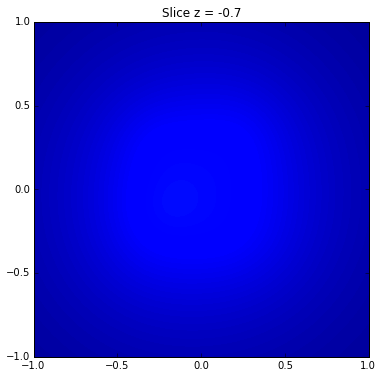

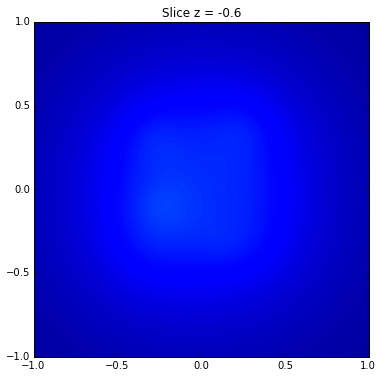

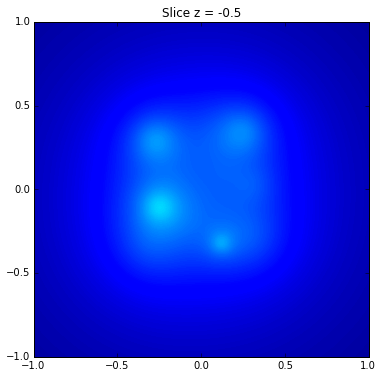

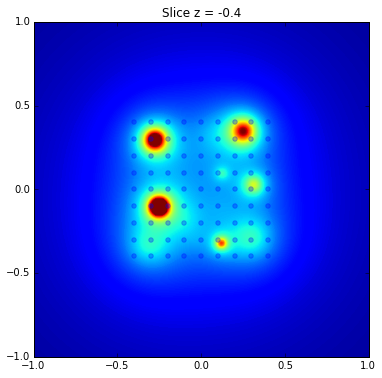

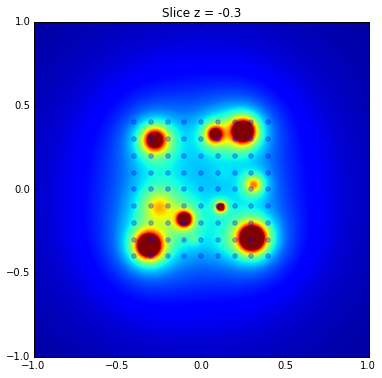

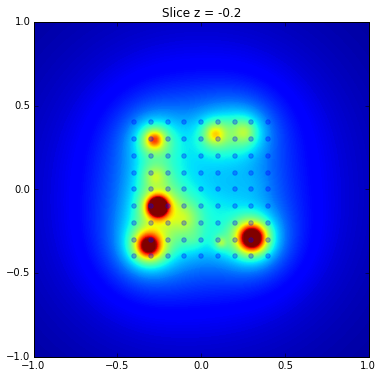

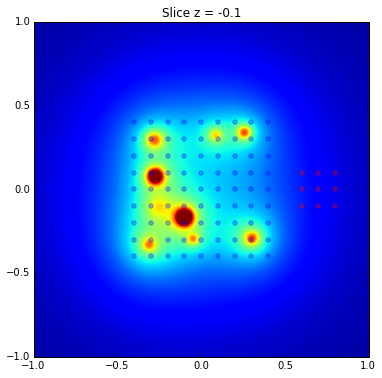

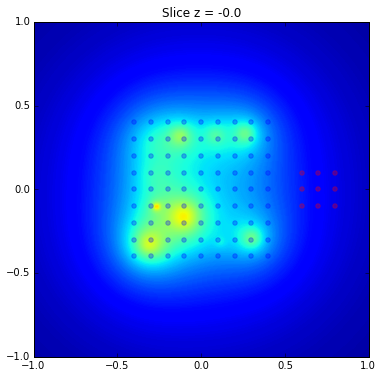

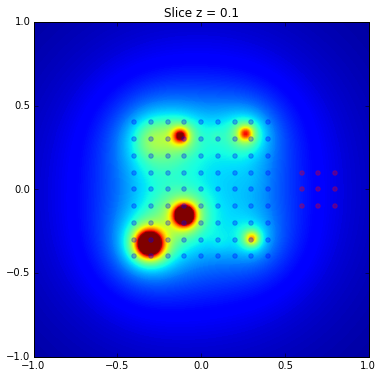

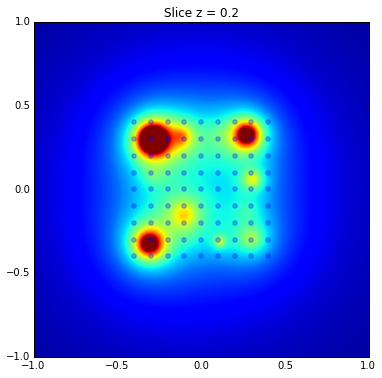

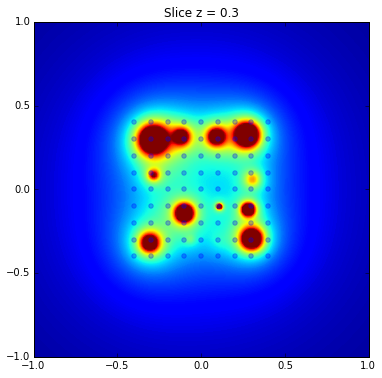

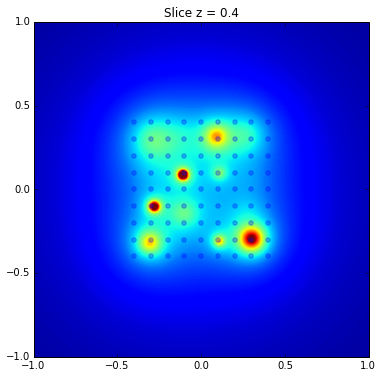

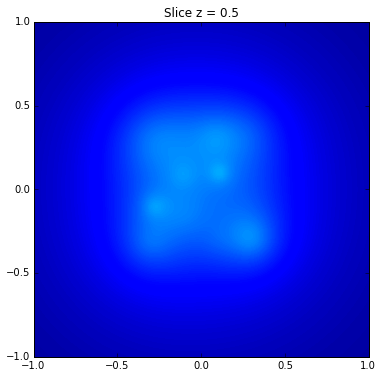

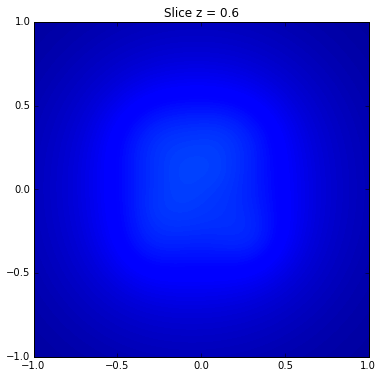

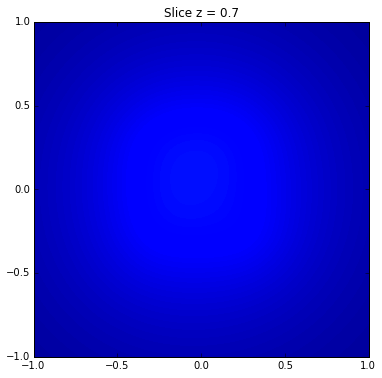

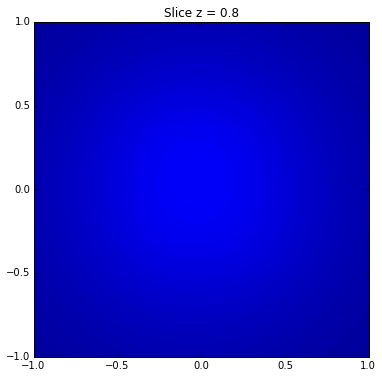

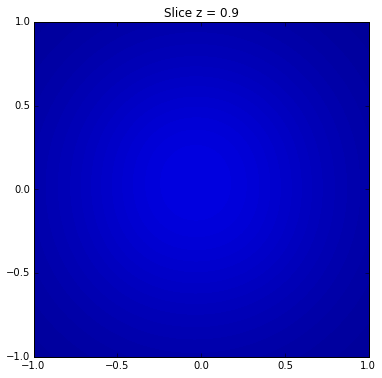

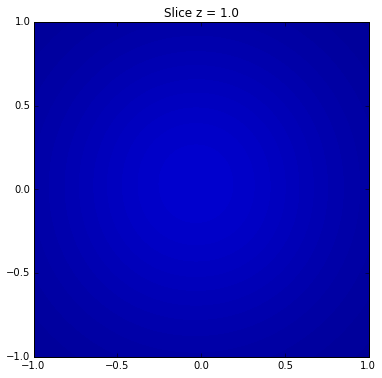

In [43]:
for i in range(21):
    plt.figure(figsize=(6,6))
    
    c = plt.contourf(contour_x_, contout_y_,
        contour_exposure[:, :, i], 250,
        vmin=0, vmax=250)
    
    reference = z[target_cube] == z_[i]
    x_target = x[target_cube][reference]
    y_target = y[target_cube][reference]
    plt.scatter(x_target, y_target, alpha=0.3, color='blue')
    
    reference = z[avoid_cube] == z_[i]
    x_avoid = x[avoid_cube][reference]
    y_avoid = y[avoid_cube][reference]
    plt.scatter(x_avoid, y_avoid, alpha=0.3, color='red')
    
    plt.title("Slice z = %0.1f" % (z_[i]))
#     plt.colorbar(c)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.show()

Create analysis grid

In [37]:
dx = 0.02
dy = 0.02
dz = 0.02

post_x_ = np.arange(-1, 1 + dx, dx)
post_y_ = np.arange(-1, 1 + dy, dy)
post_z_ = np.arange(-1, 1 + dz, dz)

post_x, post_y, post_z = np.meshgrid(
    post_x_, post_y_, post_z_)
post_x = np.ravel(post_x)
post_y = np.ravel(post_y)
post_z = np.ravel(post_z)

post_exposure = custom_res_calculate_exposure(dwell_times, dx=dx, dy=dy, dz=dz)
post_exposure[post_exposure > 150] = 150

Define structures on new finer grid

In [38]:
post_target_cube = (
    (post_x < 0.45) & (post_x > -0.45) & 
    (post_y < 0.45) & (post_y > -0.45) & 
    (post_z < 0.45) & (post_z > -0.45))

post_avoid_cube = (
    (post_x < 0.85) & (post_x > 0.55) & 
    (post_y < 0.15) & (post_y > -0.15) & 
    (post_z < 0.15) & (post_z > -0.15))

Make a function to plot DVHs given a reference

In [39]:
def create_dvh(reference, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    
    results = post_exposure[reference]
    hist = np.histogram(results, 100)
    
    freq = hist[0]
    bin_edge = hist[1]
    bin_mid = (bin_edge[1::] + bin_edge[:-1:])/2
    
    cumulative = np.cumsum(freq[::-1])
    cumulative = cumulative[::-1]
    bin_mid = np.append([0], bin_mid)
    
    cumulative = np.append(cumulative[0], cumulative)
    percent_cumulative = cumulative / cumulative[0] * 100

    ax.plot(bin_mid, percent_cumulative)

Plotting of relevant DVHs

(0, 150)

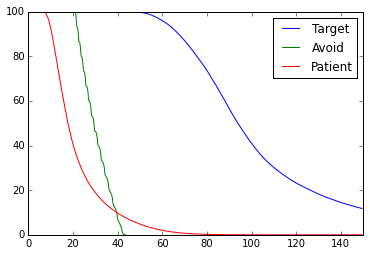

In [40]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, ax=ax)
create_dvh(post_avoid_cube, ax=ax)
create_dvh(~post_target_cube, ax=ax)

plt.legend(["Target", "Avoid", "Patient"])

plt.xlim([0, 150])